## Parse patient zero results - proximity

In [1]:
import numpy as np
import numba as nb
import pandas as pd

import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '../../src')
import networkx as nx

In [2]:
import io_m.libsaving as libsaving
import io_m.io_utils as io_utils

from importlib import reload

In [3]:
from epigen import epidemy_gen

In [4]:
from epigen.base import EpInstance

In [5]:
type_graph="i_bird"
N=10
d=3
height=3
lam=0.5
mu=1e-6
t_limit=12
scale=2
#gamma=1e-3
#path_contacts="../patient_zero/work/work_13_contacts.npz"
#small_lambda_limit=0

gamma=7e-5
small_lambda_limit=300
path_contacts="work_13_contacts.npz"
path_contacts="i_bird_contacts.npz"

#path_contacts="i_bird_contacts.npz"

p_edge=1
nsrc=1


In [6]:
seeds=range(1,2)

In [7]:
INSTANCES = {s:EpInstance(type_graph, N, d, t_limit, 
                                    lam, mu, s, float(p_edge), 
                                    n_source=nsrc) for s in seeds}

In [8]:
str(INSTANCES[1])

'i_bird_n_10_d_3_tlim_12_lam_0.5_mu_1e-06_s_1_pe_1.0'

In [9]:
extra_gen = {"h":height,
            "scale":scale}

extra_gen.update({"gamma":gamma, 
                  "small_lambda_limit":small_lambda_limit, 
                  "path_contacts": path_contacts})

In [10]:
start_conf=0
num_conf=100

In [11]:
reload(epidemy_gen)
sources=set([50])
DATA_ALL = {s: 
            epidemy_gen.epidemy_gen_epinstance(inst, 
                                               lim_infected=1, num_conf=num_conf,
                                               extra_gen=extra_gen, 
                                               verbose=False,
                                              num_sources=nsrc,
                                              sources=sources) 
            for s, inst in INSTANCES.items()}


number of contacts: 14010
Lim infected: 1, Lim max infected: 327
Num sources:  1
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources {50}
 Sources 

In [12]:
import torch
ss = torch.load("samples_ibird.torch", map_location="cpu")

In [13]:
from annfore.net import nn_sir_path_obs
from annfore.utils.graph import find_neighs
from annfore.models import common as en_common
from annfore.models import sir_model_N_obs
from annfore.learn.losses import loss_fn_coeff
from annfore.learn.train import train_beta, train_saving_marginals, make_training_step_local
from annfore.learn.opt import make_opt

from annfore.learn.train_params import opt_param_init, train_beta_params
from annfore.learn.train_params import learn_lamb_mu, learn_gamma_mu
from annfore.learn.l_utils import make_beta_sequence_three as make_beta_seq
# func_layers = [1, 1]
contacts = DATA_ALL[1]["contacts"]
N = int(max(contacts[:, 1]) + 1)
mu = 0
device = "cpu"
model_free = sir_model_N_obs.SirModel(contacts,
                        mu = 0,
                        device = device,
                            p_source=1,
                            p_obs=1,
                            p_w=1e-30)
sample_free = []
num_sample = 100
for epid in range(len(DATA_ALL[1]["epidemy"]))[:num_sample]:
    sample_free.append(DATA_ALL[1]["epidemy"][epid][0][0])
sample_free = torch.Tensor(sample_free)
sample_free[sample_free == float("Inf")] = 13
clone_ss = ss[:num_sample].clone()
clone_ss[:,:,0] = sample_free[:]+1
clone_ss[clone_ss >13] = 13
logp_net, _,_,_ = model_free.energy_separated(ss)
logp_sim, _,_,_ = model_free.energy_separated(clone_ss)

In [20]:
for i in range(3,100):
    DATA_ALL[1]["epidemy"][i][0][0] = ss[i][:,0]-1

import networkx as nx
DATA_ALL[1]["contacts"]
G = nx.Graph()
contacts = DATA_ALL[1]["contacts"]
N = int(max(contacts[:, 1]) + 1)
G.add_nodes_from(range(N))
for t, i, j, l in DATA_ALL[1]["contacts"]:
    G.add_edge(i,j, t=t, l=l)
#G.remove_nodes_from(list(nx.isolates(G)))
pos = nx.drawing.layout.kamada_kawai_layout(G)
#pos = nx.drawing.layout.spring_layout(G, iterations=100, k=1.5)
#pos = nx.drawing.layout.random_layout(G)
nodes_pos = np.asarray([pos[n] for n in range(N)])


(-1.085804184616743, 0.801887876951604)


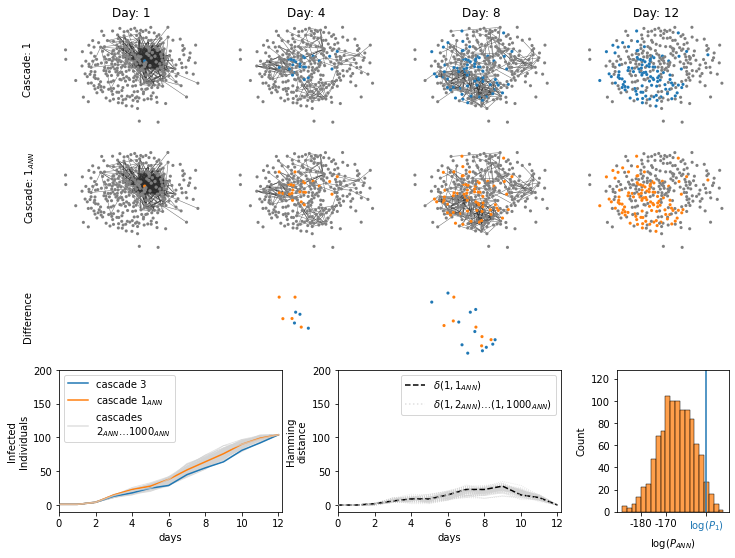

In [40]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns
import matplotlib.gridspec as gridspec

%matplotlib inline
max_T = 13
Ts = [1,4, 8,12]#
#Ts = range(1,13, 3)# 
sim_ref = 2
sim_comp = 3
fig = plt.figure(figsize=(12,9))
outer = gridspec.GridSpec(2, 1, height_ratios = [2.5, 1], hspace=-0.03) 
#make nested gridspecs
gs1 = gridspec.GridSpecFromSubplotSpec(3, 4, subplot_spec = outer[0])
gs2 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec = outer[1], wspace = 0.3, width_ratios = [2,2, 1])

#gs1 = fig.add_gridspec(4, len(Ts)*2, height_ratios=[1,1,1,3])

color = list(sns.color_palette("bright"))
color = list(sns.color_palette("tab10"))
color_ = list(sns.color_palette("Greys"))
color_S = color[7]
color_I = [color[0],color[1]]
color_E = color_[5]
color_diff = "black"
s = 40
# first two cascades
simulations = [sim_ref,sim_comp]
T_inf_confs={}
nodes_diff = {}
for i_axs, simulation in enumerate(simulations):
    t_infs = DATA_ALL[1]["epidemy"][simulation][0][0]
    parent = DATA_ALL[1]["epidemy"][simulation][0][1]
    T_inf_confs[i_axs] = []
    for ii, T in enumerate(Ts):#range(max_T):#
        ax = fig.add_subplot(gs1[i_axs, ii])
        edgelist = [(u,v) for u,v,e in G.edges(data=True) if e["t"] == T]
        edge_pos = np.asarray([(pos[e[0]], pos[e[1]]) for e in edgelist])
        edge_l = np.clip(3*np.asarray([e["l"] for u,v,e in G.edges(data=True) if e["t"] == T]),a_min=0, a_max=0.5)
        if i_axs == 0:
            ax.set_title(f"Day: {T}")

        lines = [[(x[0][0], x[0][1]), (x[1][0], x[1][1])] for x in edge_pos]
        #ax.plot(y_edges_pos, x_edges_pos, len(x_edges_pos)*[t],"o-", alpha=0.8)
        #ax.plot(y_edges_pos, x_edges_pos ,"o-", alpha=0.8)
        lc = LineCollection(lines, linewidths=0.5, alpha=0.7, zorder=3, color=color_E)
        ax.add_collection(lc)
        nodes_color = [color_S if T <= t_infs[int(i)] else color_I[i_axs] for i in range(N) ]
        T_inf_confs[i_axs].append(np.array([int(T > t_infs[int(i)]) for i in range(N)]))
        ax.scatter(nodes_pos[:,0], nodes_pos[:,1], 
        marker=".", alpha=1, 
        color = nodes_color, 
        s=s,
        zorder=4,
        ec="white",
        linewidth=0.05)
        #plot_networkx_on_map(G, ax, pos)
        ax.axis('off')
        if ii == 0 and i_axs==0:
            ax.text(-1.5,-0.5, f"Cascade: 1", rotation="vertical")
        if ii == 0 and i_axs==1:
            ax.text(-1.5,-0.5, "Cascade: $1_{ANN}$", rotation="vertical")




#diff cascade
x_lim = plt.xlim()
y_lim = plt.ylim()
print(y_lim)
i_axs = 2
    #edgelist = list(G.edges())

for ii, T in enumerate(Ts):#range(max_T):#
    ax = fig.add_subplot(gs1[i_axs, ii])
    #ax = fig.add_subplot()
    nodes_diff = T_inf_confs[0][ii] - T_inf_confs[1][ii] 
    nodes_list_add = np.array([True if nodes_diff[int(i)] != 0 else False for i in range(N) ])
    #print(f"{nodes_list_add.sum()}, {T_inf_confs[0][ii].sum()}, , {T_inf_confs[1][ii].sum()}")
    nodes_to_pos = np.argwhere(nodes_list_add)[:,0]
    if ii == 0:
        #ax.text(-1.5,-0.5, f"Diffrence", rotation="vertical")
        ax.text(-0.25,0.35, f"Difference", rotation="vertical")

    nodes_list_color = [color_I[0] if nodes_diff[int(i)] == 1 else color_I[1] for i in np.argwhere(nodes_list_add) ]
    nodes_pos_diff = np.asarray([pos[n] for n in nodes_to_pos])
    if len(nodes_to_pos) > 0 :
        ax.scatter(nodes_pos_diff[:,0], nodes_pos_diff[:,1], 
        marker=".", alpha=1, 
        color = nodes_list_color, 
        s=s,
        zorder=4,
        ec="white",
        linewidth=0.05)
        #plot_networkx_on_map(G, ax, pos)
        ax.axis('off')
        ax.set_xlim(x_lim)
        ax.set_ylim(y_lim)
    else:
        
        ax.axis('off')


T_inf_confs = {}
Ts=range(0,max_T)
ax1 = fig.add_subplot(gs2[0, 0])
ax2 = fig.add_subplot(gs2[0, 1])
simulations_over = range(num_conf)
for i_axs, simulation in enumerate(simulations_over):
    t_infs = ss[simulation][:,0]-1
    #edgelist = list(G.edges())
    T_inf_confs[simulation] = []
    for ii, T in enumerate(Ts):#range(max_T):#
        T_inf_confs[simulation].append(np.array([int(T > t_infs[int(i)]) for i in G.nodes()]))
overlap_ = {}
Is = {}
sims_df = []
for i_axs, simulation in enumerate(simulations_over):
    overlap_[simulation] = []
    Is[simulation] = []
    for i in range(len(T_inf_confs[0])):
        overlap_[simulation].append(abs(T_inf_confs[sim_ref][i] - T_inf_confs[simulation][i]).sum())
        Is[simulation].append(T_inf_confs[simulation][i].sum())
        sims_df.append({"sim":simulation, "over":overlap_[simulation][-1],"day":i, "I":Is[simulation][-1]})

for i_axs, simulation in enumerate(simulations_over[0:-1]):
    if i_axs != sim_ref:
        ax2.plot(overlap_[simulation], ":", color="lightgrey", alpha=0.7, lw=0.8)
for i_axs, simulation in enumerate(simulations_over[:-1]):
    ax1.plot(Is[simulation], color="lightgrey", alpha=0.7, lw=0.8)

#ax2.plot(overlap_[simulations_over[sim_ref]], color="blue", label="perfect overlap")


sims_df=pd.DataFrame(sims_df)
#sns.lineplot(x="day", y="I", ax=ax1, data=sims_df, ci="sd")
#sns.lineplot(x="day", y="over", ax=ax2, data=sims_df, ci="sd")

ax1.plot(Is[sim_ref], color=color_I[0], label=f"cascade {sim_ref+1}")
ax1.plot(Is[sim_comp], color=color_I[1], label="cascade $1_{ANN}$")

ax2.plot(overlap_[sim_comp], "--", color="black", label="$\delta(1, 1_{ANN})$")
ax1.plot(Is[simulations_over[-1]], color="lightgrey", alpha=0.7, label="cascades \n$2_{ANN}\dots1000_{ANN}$", zorder=4)
ax2.plot(overlap_[simulations_over[-1]], ":", color="lightgrey", alpha=0.7, label="$\delta(1,2_{ANN})\dots(1,1000_{ANN})$", zorder=4)

ax1.legend()
ax2.legend()
#plt.despine()
ax1.set_ylabel("Infected\nIndividuals")
ax2.set_ylabel("Hamming\ndistance")
ax1.set_xlabel("days")
ax2.set_xlabel("days")
ax1.set_ylim(-10,200)
ax1.set_xlim(0,12.2)
ax2.set_ylim(-10,200)
ax2.set_xlim(0,12.2)

#energy
ax3 = fig.add_subplot(gs2[0, 2])
#ax3.set_xlim(-200,-140)
ax = sns.histplot(x=-logp_net.numpy(), ax=ax3, color=color_I[1])
ax3.set_xticks([-130, -logp_sim[sim_ref], -170, -180])
ax3.set_xticklabels(["-130","$\log(P_{1})$", "-170", "-180"])
ax3.vlines(-logp_sim[sim_ref], 0, 135)
ax3.set_ylim(0,128);
plt.gca().get_xticklabels()[1].set_color(color_I[0]) 
ax3.set_xlabel("$\log(P_{ANN})$")
plt.show()
fig.savefig("cascade_ann.pdf", bbox_inches="tight")